In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
from dataset import FakeDatasetIsPlanar
from visualization import visualize
from model import GCN, SAGE, ConvGNN
from training.train_eval import TrainEval

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.transforms import OneHotDegree, Constant
from torch_geometric.datasets import FakeDataset
from torch_geometric.nn import GCNConv
from torch import nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import torch
import random
import numpy as np


# Dataset

In [18]:
help(FakeDatasetIsPlanar.__init__)

Help on function __init__ in module dataset.planar:

__init__(self, num_graphs: int, avg_num_nodes: int = 1000, avg_degree: int = 10, edge_dim: int = 0, is_undirected: bool = True, transform: Optional[Callable] = None, pre_transform: Optional[Callable] = None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



In [19]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_small = FakeDatasetIsPlanar(num_graphs=100000, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=one_hot_degree)
print(f"Planar graphs: {int(ds_small.y.sum())}")
ds_small

Planar graphs: 21646
CPU times: user 24.1 s, sys: 96 ms, total: 24.2 s
Wall time: 24.4 s


FakeDatasetIsPlanar(100000)

In [20]:
ds_small[100]

Data(edge_index=[2, 44], y=[1], is_planar=[1], pos=[10, 2], num_nodes=10, x=[10, 11])

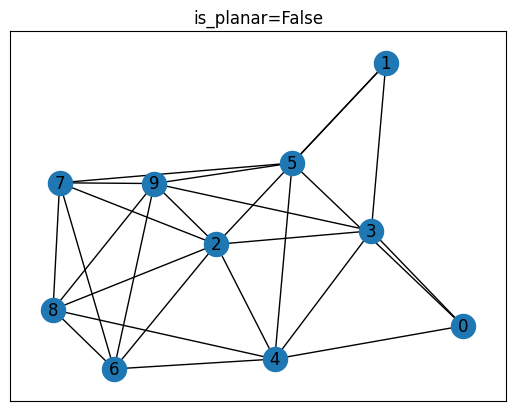

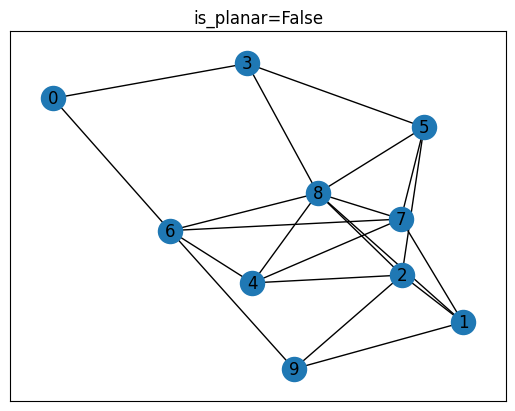

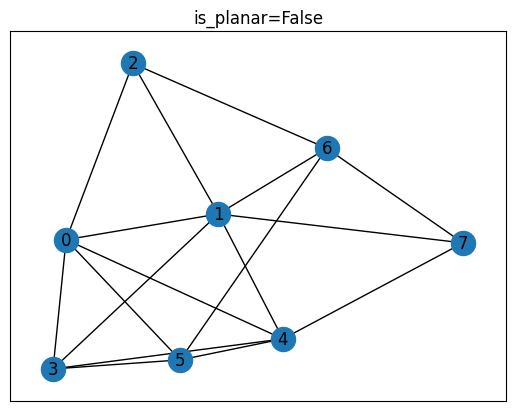

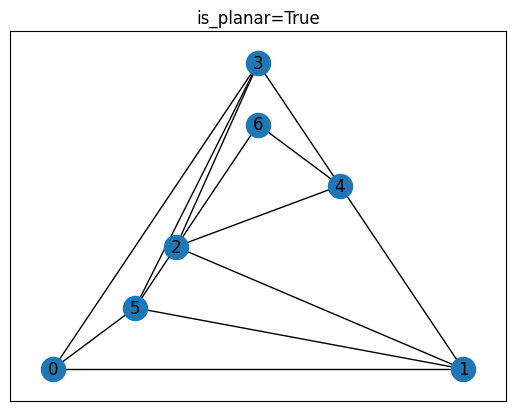

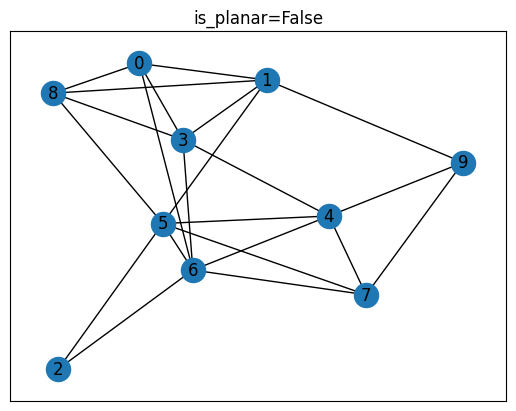

In [21]:
for data in ds_small[:5]:
    visualize(data)
    plt.show()

# Train a simple 3-layer GNN with a final average pooling

The model code is taken from "Graph Classification" example https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html

In [22]:
ds_small_shuffled = ds_small.shuffle()
N = len(ds_small)
train_count = int(N*0.8)
train_ds_small = ds_small_shuffled[:train_count]
test_ds_small = ds_small_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds_small)}')
print(f'Number of test graphs: {len(test_ds_small)}')

Number of training graphs: 80000
Number of test graphs: 20000


In [23]:
train_loader = DataLoader(train_ds_small, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds_small, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2322], y=[64], is_planar=[64], pos=[510, 2], num_nodes=510, x=[510, 11], batch=[510], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2370], y=[64], is_planar=[64], pos=[519, 2], num_nodes=519, x=[519, 11], batch=[519], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2212], y=[64], is_planar=[64], pos=[497, 2], num_nodes=497, x=[497, 11], batch=[497], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2338], y=[64], is_planar=[64], pos=[515, 2], num_nodes=515, x=[515, 11], batch=[515], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2432], y=[64], is_planar=[64], pos=[526, 2], num_nodes=526, x=[526, 11], batch=[526], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2256], y=[64], is_planar=[64], pos=[507, 2], num_nodes=507, x=[50

In [51]:
class GCN(nn.Module):
    def __init__(self, hidden_channels, num_node_features, num_classes, manual_seed=12345):
        super(GCN, self).__init__()
        if manual_seed is not None:
            torch.manual_seed(manual_seed)
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

#model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
#           num_classes=ds_small.num_classes)
#print(model)

In [25]:
model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
           num_classes=ds_small.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     tp = 0
     fn = 0
     fp = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         tp += int(((pred == 1)*(data.y == 1)).sum())
         fn += int(((pred == 0)*(data.y == 1)).sum())
         fp += int(((pred == 1)*(data.y == 0)).sum())

     total = len(loader.dataset)
     accuracy = (total - fp - fn) / total
     precision = tp / (tp + fp + 1e-9)
     recall = tp / (tp + fn + 1e-9)
     f1 = 2*recall*precision / (recall + precision + 1e-9)
     #print(f'total={total}, tp={tp}, fp={fp}, fn={fn}')
     return accuracy, precision, recall, total, f1
     
    
def fmt(accuracy, precision, recall, total, f1):
    return f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}, size={total}"

train_metrics_per_epoch = []
test_metrics_per_epoch = []

for epoch in range(1, 70):
    train()
    train_metrics = test(train_loader)
    test_metrics = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train: {fmt(*train_metrics)}, Test: {fmt(*test_metrics)}')
    train_metrics_per_epoch.append(train_metrics)
    test_metrics_per_epoch.append(test_metrics)

Epoch: 001, Train: accuracy=0.9394, precision=0.8404, recall=0.8890, f1=0.8641, size=80000, Test: accuracy=0.9418, precision=0.8436, recall=0.8963, f1=0.8691, size=20000
Epoch: 002, Train: accuracy=0.9487, precision=0.8751, recall=0.8906, f1=0.8828, size=80000, Test: accuracy=0.9507, precision=0.8774, recall=0.8967, f1=0.8870, size=20000
Epoch: 003, Train: accuracy=0.9448, precision=0.8420, recall=0.9173, f1=0.8780, size=80000, Test: accuracy=0.9475, precision=0.8447, recall=0.9264, f1=0.8837, size=20000
Epoch: 004, Train: accuracy=0.9524, precision=0.8666, recall=0.9223, f1=0.8936, size=80000, Test: accuracy=0.9542, precision=0.8681, recall=0.9285, f1=0.8973, size=20000
Epoch: 005, Train: accuracy=0.9401, precision=0.8072, recall=0.9503, f1=0.8729, size=80000, Test: accuracy=0.9401, precision=0.8047, recall=0.9534, f1=0.8727, size=20000
Epoch: 006, Train: accuracy=0.9495, precision=0.8496, recall=0.9317, f1=0.8888, size=80000, Test: accuracy=0.9502, precision=0.8492, recall=0.9346, f1

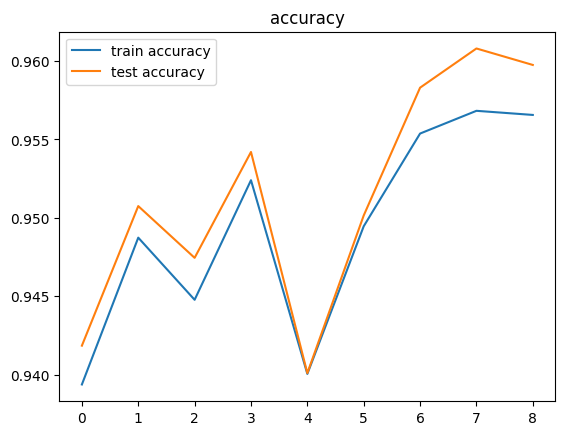

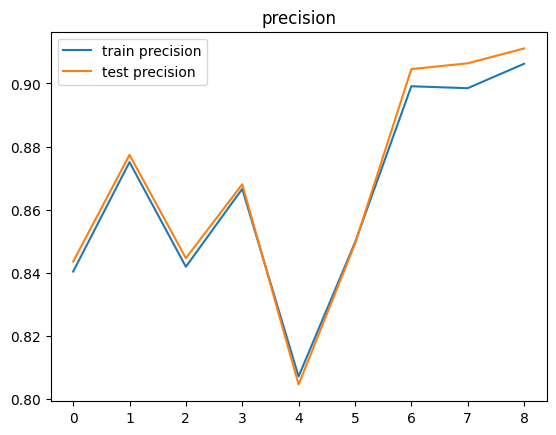

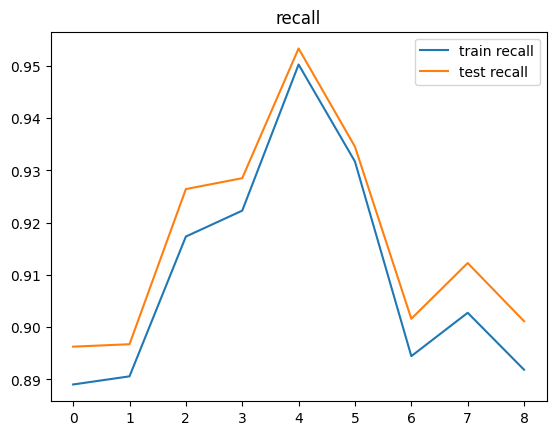

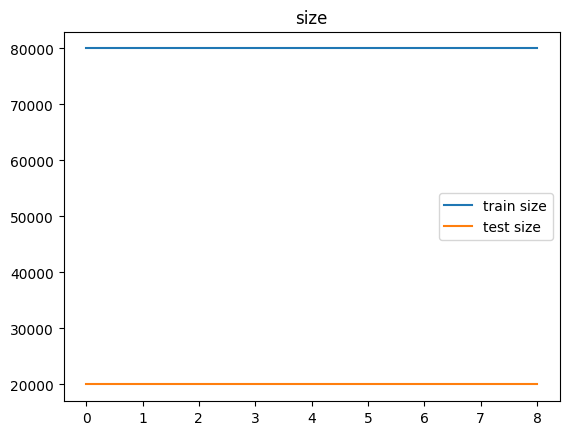

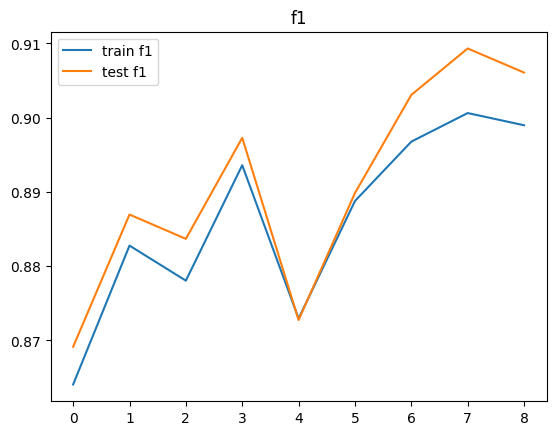

In [26]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Train on 100k dataset

In [27]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_100k = FakeDatasetIsPlanar(num_graphs=100000, avg_num_nodes=8, avg_degree=avg_degree,
                              transform=one_hot_degree)
print(f"Planar graphs: {int(ds_100k.y.sum())}")
ds_100k

Planar graphs: 21646
CPU times: user 24.4 s, sys: 52.7 ms, total: 24.5 s
Wall time: 24.1 s


FakeDatasetIsPlanar(100000)

....

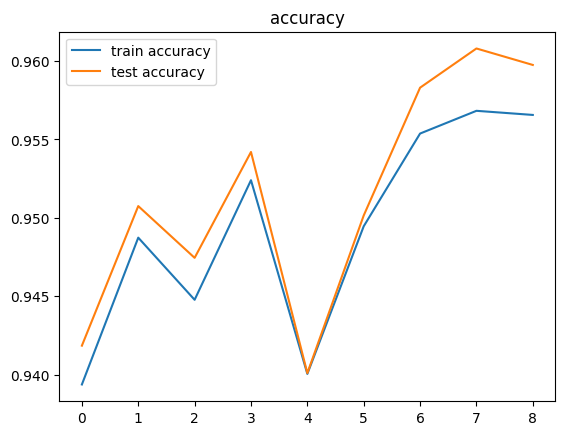

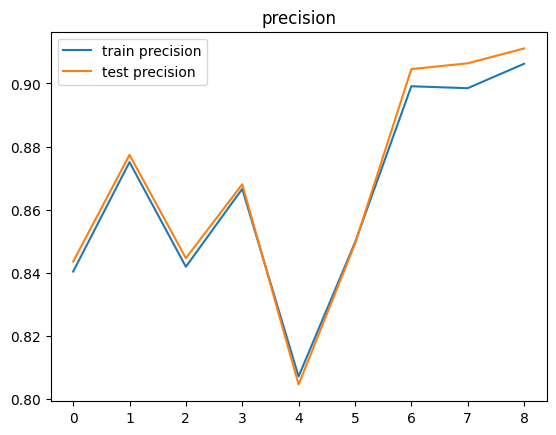

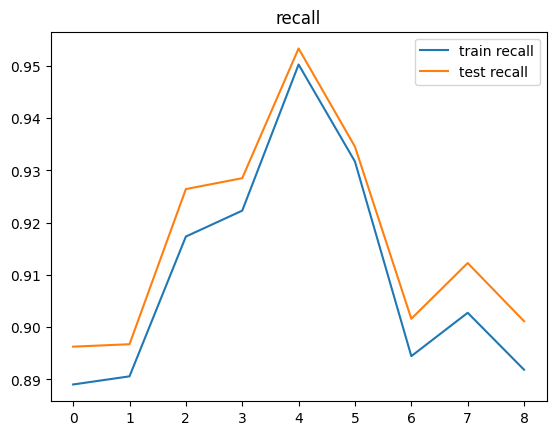

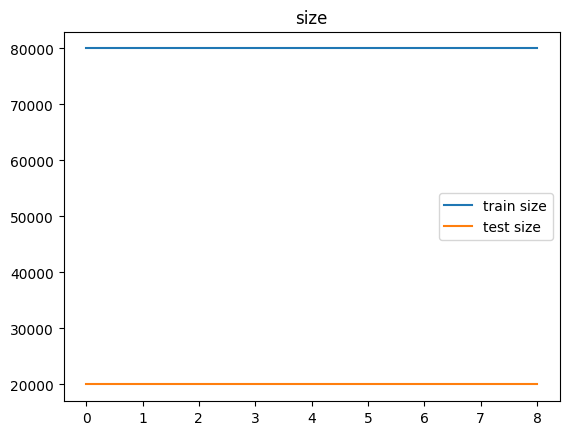

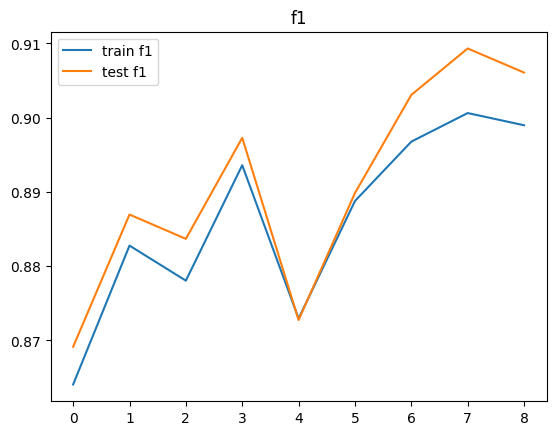

In [28]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Train on 1mln dataset

In [43]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

one_hot_degree = OneHotDegree(max_degree, cat=False)

ds_mln = FakeDatasetIsPlanar(num_graphs=1000000, avg_num_nodes=8, avg_degree=avg_degree,
                             transform=one_hot_degree)
print(f"Planar graphs: {int(ds_mln.y.sum())}")
ds_mln

Planar graphs: 216652
CPU times: user 4min 9s, sys: 1.66 s, total: 4min 11s
Wall time: 4min 14s


FakeDatasetIsPlanar(1000000)

In [30]:
ds_mln_shuffled = ds_mln.shuffle()
N = len(ds_mln)
train_count = int(N*0.8)
train_ds = ds_mln_shuffled[:train_count]
test_ds = ds_mln_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds)}')
print(f'Number of test graphs: {len(test_ds)}')

Number of training graphs: 800000
Number of test graphs: 200000


In [31]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2220], y=[64], is_planar=[64], pos=[497, 2], num_nodes=497, x=[497, 11], batch=[497], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2142], y=[64], is_planar=[64], pos=[498, 2], num_nodes=498, x=[498, 11], batch=[498], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2254], y=[64], is_planar=[64], pos=[510, 2], num_nodes=510, x=[510, 11], batch=[510], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2382], y=[64], is_planar=[64], pos=[522, 2], num_nodes=522, x=[522, 11], batch=[522], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2212], y=[64], is_planar=[64], pos=[504, 2], num_nodes=504, x=[504, 11], batch=[504], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2204], y=[64], is_planar=[64], pos=[498, 2], num_nodes=498, x=[49

In [32]:
model = GCN(hidden_channels=11, num_node_features=ds_small.num_node_features,
           num_classes=ds_small.num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     tp = 0
     fn = 0
     fp = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         tp += int(((pred == 1)*(data.y == 1)).sum())
         fn += int(((pred == 0)*(data.y == 1)).sum())
         fp += int(((pred == 1)*(data.y == 0)).sum())

     total = len(loader.dataset)
     accuracy = (total - fp - fn) / total
     precision = tp / (tp + fp + 1e-9)
     recall = tp / (tp + fn + 1e-9)
     f1 = 2*recall*precision / (recall + precision + 1e-9)
     #print(f'total={total}, tp={tp}, fp={fp}, fn={fn}')
     return accuracy, precision, recall, total, f1

def fmt(accuracy, precision, recall, total, f1):
    return f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}, size={total}"

train_metrics_per_epoch = []
test_metrics_per_epoch = []

for epoch in range(1, 70):
    train()
    train_metrics = test(train_loader)
    test_metrics = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train: {fmt(*train_metrics)}, Test: {fmt(*test_metrics)}')
    train_metrics_per_epoch.append(train_metrics)
    test_metrics_per_epoch.append(test_metrics)

Epoch: 001, Train: accuracy=0.9626, precision=0.9336, recall=0.8908, f1=0.9117, size=800000, Test: accuracy=0.9624, precision=0.9320, recall=0.8910, f1=0.9110, size=200000
Epoch: 002, Train: accuracy=0.9637, precision=0.9273, recall=0.9032, f1=0.9151, size=800000, Test: accuracy=0.9634, precision=0.9266, recall=0.9023, f1=0.9143, size=200000
Epoch: 003, Train: accuracy=0.9658, precision=0.9219, recall=0.9200, f1=0.9210, size=800000, Test: accuracy=0.9657, precision=0.9212, recall=0.9202, f1=0.9207, size=200000
Epoch: 004, Train: accuracy=0.9659, precision=0.9325, recall=0.9085, f1=0.9203, size=800000, Test: accuracy=0.9655, precision=0.9314, recall=0.9070, f1=0.9191, size=200000
Epoch: 005, Train: accuracy=0.9653, precision=0.9351, recall=0.9027, f1=0.9186, size=800000, Test: accuracy=0.9651, precision=0.9341, recall=0.9024, f1=0.9180, size=200000
Epoch: 006, Train: accuracy=0.9634, precision=0.9338, recall=0.8946, f1=0.9138, size=800000, Test: accuracy=0.9629, precision=0.9323, recall

KeyboardInterrupt: 

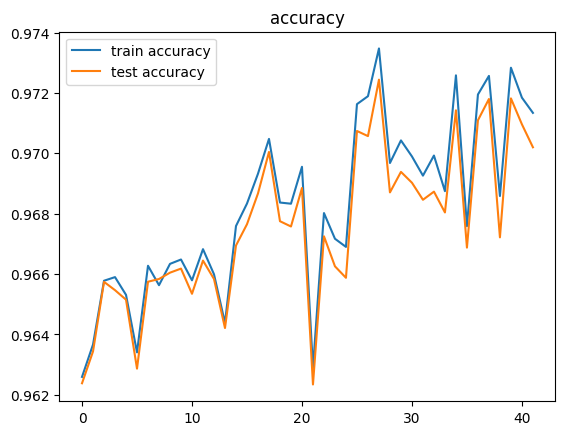

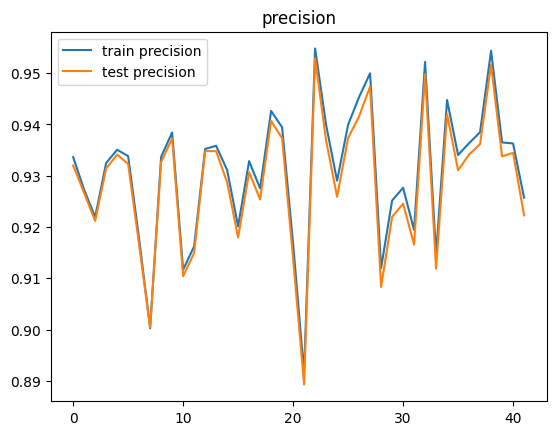

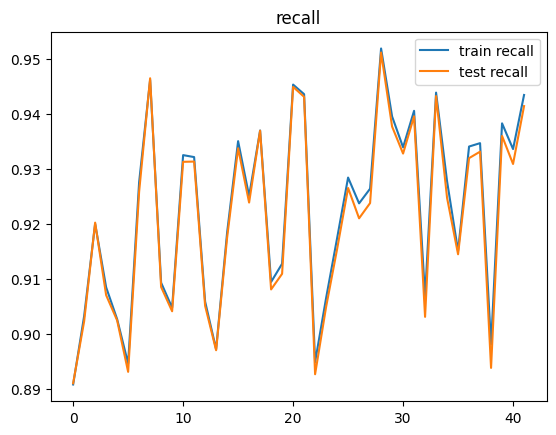

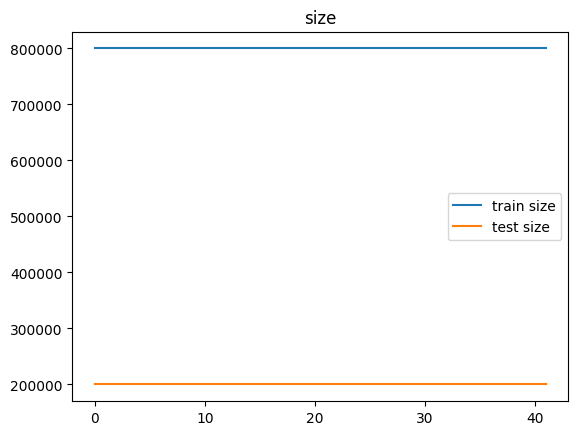

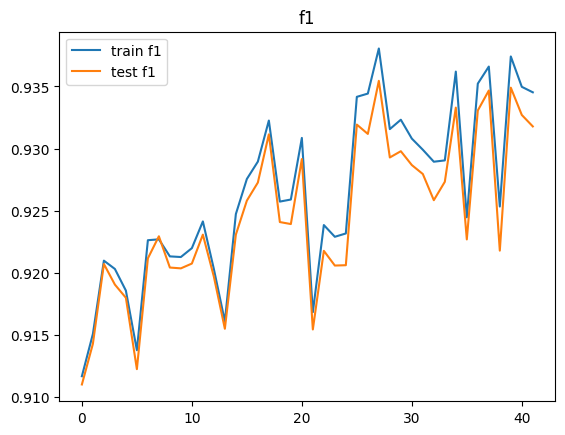

In [33]:
for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Conclusions

F1 metric converges after ~60 epoch to 0.985 on the 1mln dataset and to 0.982 on the 100k dataset. Accuracy is ~97% Metrics doesn't show any signs of overfitting.

Subjectively, it's unexpectedly good.

## Questions:
1. Is the dataset too simple? May the task be solved without using the graph structure?
2. Will the quality grow when making the model more complex?

# Solving the task without graph structure - 1mln dataset

In [44]:
ds_mln

FakeDatasetIsPlanar(1000000)

In [45]:
ds_mln_shuffled = ds_mln.shuffle()
N = len(ds_mln_shuffled)
train_count = int(N*0.8)
train_ds = ds_mln_shuffled[:train_count]
test_ds = ds_mln_shuffled[train_count:]

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print(f'Number of training graphs: {len(train_ds)}')
print(f'Number of test graphs: {len(test_ds)}')

Number of training graphs: 800000
Number of test graphs: 200000


## Extract the sum of one-hot degree vectors for each graph

In [46]:
from dataset import sum_node_features

torch.Size([5, 11])
tensor([0., 0., 0., 1., 2., 3., 0., 0., 0., 0., 0.])


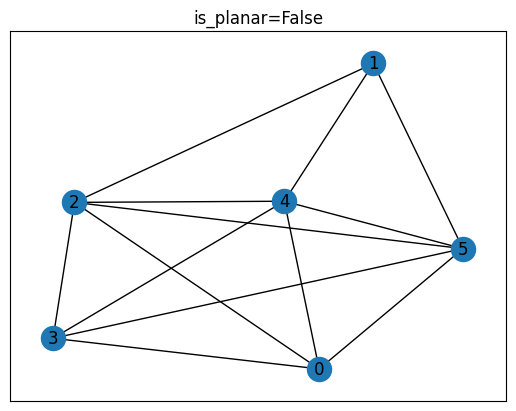

tensor([0., 0., 0., 1., 3., 2., 1., 1., 0., 0., 0.])


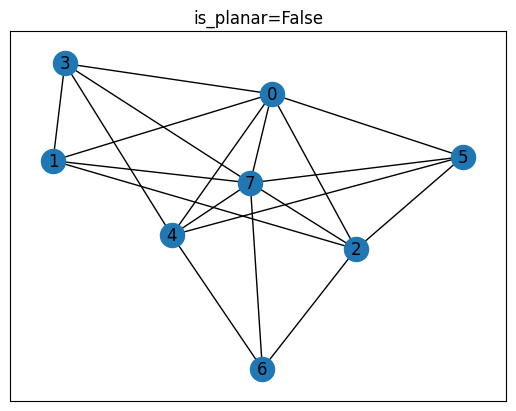

tensor([0., 0., 1., 1., 3., 1., 1., 0., 0., 0., 0.])


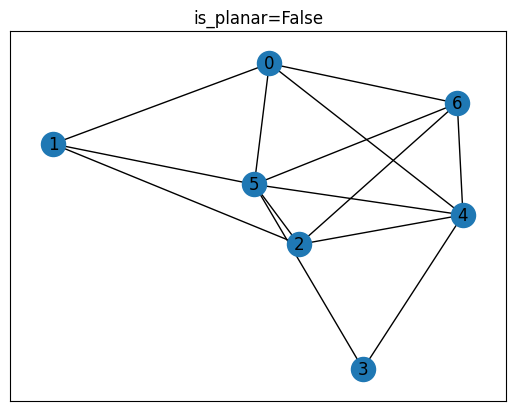

tensor([0., 0., 0., 2., 5., 1., 0., 1., 0., 0., 0.])


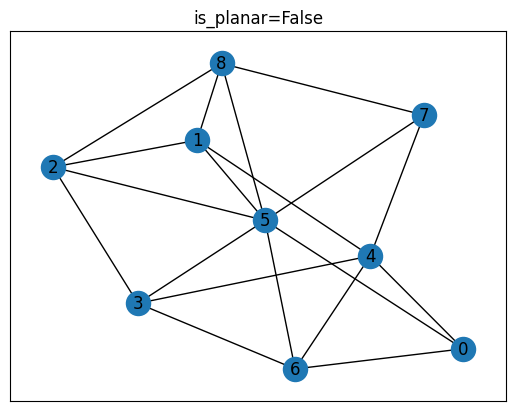

tensor([0., 1., 0., 2., 2., 1., 0., 0., 0., 0., 0.])


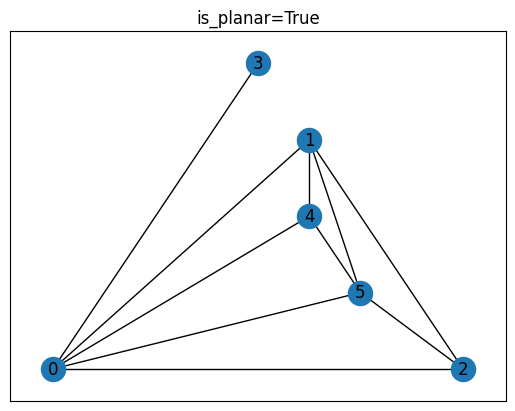

In [55]:
from dataset.sum_node_features import _test_sum_node_features

_test_sum_node_features(train_ds)

## Several FC layers trained on the sum of one-hot degree vectors:

x = 11-dim integer vector

y = is planar

In [ ]:
fc_model = nn.Sequential(
    nn.Linear(11, 100),
    nn.ReLU(),
    nn.Linear(100, 1000),
    nn.ReLU(),
    nn.Linear(1000, 100),
    nn.ReLU(),
    nn.Linear(100, 10),
    nn.ReLU(),
    nn.Linear(10, 2),
)

optimizer = torch.optim.Adam(fc_model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train(model, loader):
    model.train()
    losses = []
    for data in loader:  # Iterate in batches over the training dataset.
         x = sum_node_features(data)
         
         out = model(x)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         losses.append(loss.clone().detach())
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(model, loader):
     model.eval()

     tp = 0
     fn = 0
     fp = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         x = sum_node_features(data)
         
         out = model(x)
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         #print('out shape:', out.shape, 'pred shape:', pred.shape)
         tp += int(((pred == 1)*(data.y == 1)).sum())
         fn += int(((pred == 0)*(data.y == 1)).sum())
         fp += int(((pred == 1)*(data.y == 0)).sum())

     total = len(loader.dataset)
     accuracy = (total - fp - fn) / total
     precision = tp / (tp + fp + 1e-9)
     recall = tp / (tp + fn + 1e-9)
     f1 = 2*recall*precision / (recall + precision + 1e-9)
     return accuracy, precision, recall, total, f1

def fmt(accuracy, precision, recall, total, f1):
    return f"accuracy={accuracy:.4f}, precision={precision:.4f}, recall={recall:.4f}, f1={f1:.4f}, size={total}"

train_metrics_per_epoch = []
test_metrics_per_epoch = []

for epoch in range(1, 70):
    train(fc_model, train_loader)
    train_metrics = test(fc_model, train_loader)
    test_metrics = test(fc_model, test_loader)
    print(f'Epoch: {epoch:03d}, Train: {fmt(*train_metrics)}, Test: {fmt(*test_metrics)}')
    train_metrics_per_epoch.append(train_metrics)
    test_metrics_per_epoch.append(test_metrics)

for metric_idx, metric_name in enumerate(['accuracy', 'precision', 'recall', 'size', 'f1']):
    plt.plot([t[metric_idx] for t in train_metrics_per_epoch], label=f'train {metric_name}')
    plt.plot([t[metric_idx] for t in test_metrics_per_epoch], label=f'test {metric_name}')
    plt.title(metric_name)
    plt.legend()
    plt.show()


# Constant feature vector - 100k

The GNN will only have the graph structure as an input

In [35]:
%%time

torch.manual_seed(1234)
np.random.seed(3241)
random.seed(4534)

avg_degree = 4
max_degree = avg_degree * 5 // 2

constant = Constant(value=1.0, cat=False)

ds_small = FakeDatasetIsPlanar(num_graphs=10000, avg_num_nodes=8, avg_degree=avg_degree,
                               transform=constant)

print(f"Planar graphs: {int(ds_small.y.sum())}")
ds_small

Planar graphs: 2193
CPU times: user 2.43 s, sys: 6.87 ms, total: 2.43 s
Wall time: 2.44 s


FakeDatasetIsPlanar(10000)

In [38]:
ds_small.num_node_features, ds_small.num_classes, ds_small[0]

(1,
 2,
 Data(edge_index=[2, 50], y=[1], is_planar=[1], pos=[10, 2], num_nodes=10, x=[10, 1]))

In [37]:
ds_small_shuffled = ds_small.shuffle()
N = len(ds_small_shuffled)
train_count = int(N*0.8)
train_ds_small = ds_small_shuffled[:train_count]
test_ds_small = ds_small_shuffled[train_count:]

print(f'Number of training graphs: {len(train_ds_small)}')
print(f'Number of test graphs: {len(test_ds_small)}')

train_loader = DataLoader(train_ds_small, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds_small, batch_size=64, shuffle=False)

Number of training graphs: 8000
Number of test graphs: 2000


In [29]:
new_model = GCN(hidden_channels=10, num_node_features=ds_small.num_node_features,
                num_classes=ds_small.num_classes, apply_dropout=False)
print(new_model)

GCN(
  (conv1): GCNConv(1, 10)
  (conv2): GCNConv(10, 10)
  (conv3): GCNConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)


Epoch:  01, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000


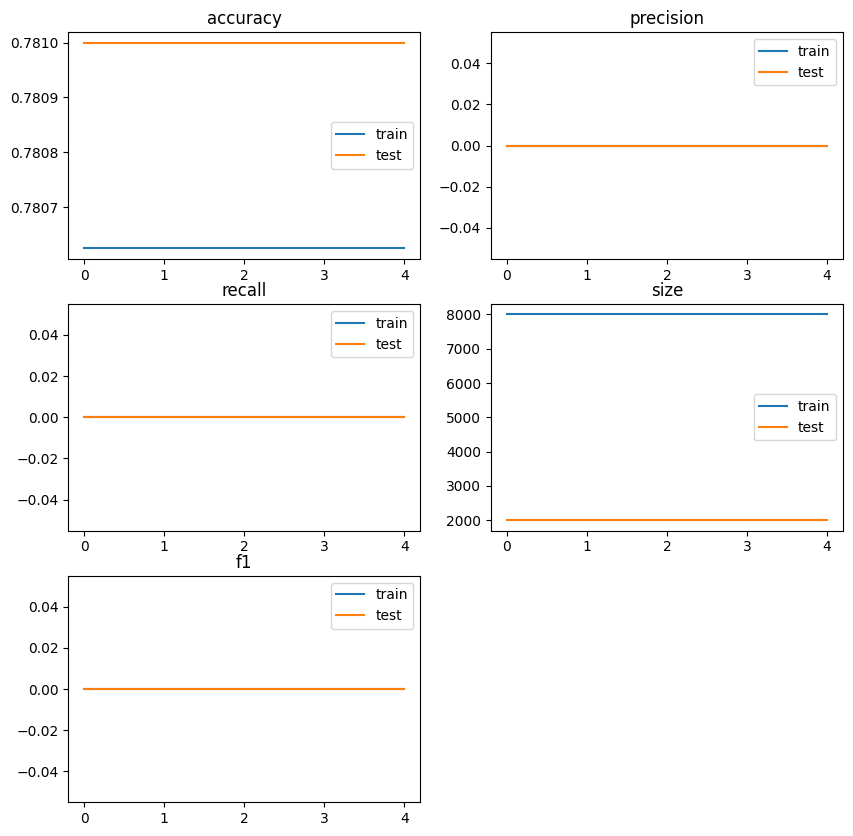

In [30]:
te = TrainEval(new_model)
te.main(5, train_loader, test_loader)

SAGE(
  (conv1): SAGEConv(1, 10, aggr=mean)
  (conv2): SAGEConv(10, 10, aggr=mean)
  (conv3): SAGEConv(10, 10, aggr=mean)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  02, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  03, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  04, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: accuracy=0.7810, precision=0.0000, recall=0.0000, size=2000.0000, f1=0.0000
Epoch:  05, Train: accuracy=0.7806, precision=0.0000, recall=0.0000, size=8000.0000, f1=0.0000, Test: acc

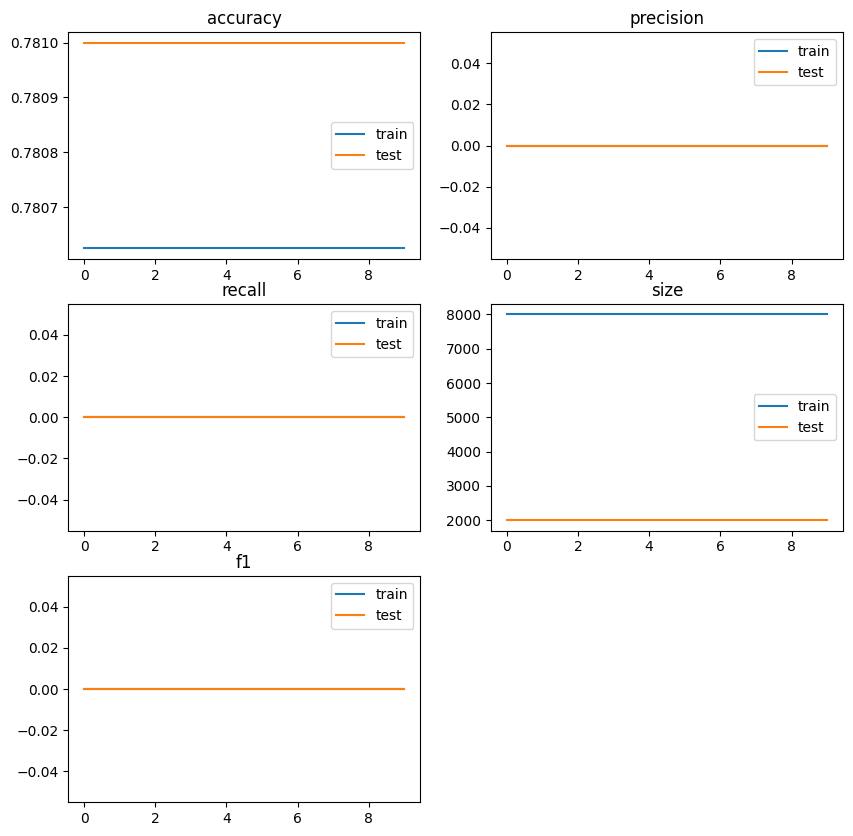

In [31]:
sage_model = SAGE(hidden_channels=10, num_node_features=ds_small.num_node_features,
                  num_classes=ds_small.num_classes, apply_dropout=False)
print(sage_model)

te = TrainEval(sage_model)
te.main(10, train_loader, test_loader)

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.8924, precision=0.8867, recall=0.5840, size=8000.0000, f1=0.7042, Test: accuracy=0.8865, precision=0.8676, recall=0.5685, size=2000.0000, f1=0.6869
Epoch:  02, Train: accuracy=0.8891, precision=0.7491, recall=0.7436, size=8000.0000, f1=0.7464, Test: accuracy=0.8845, precision=0.7435, recall=0.7215, size=2000.0000, f1=0.7323
Epoch:  03, Train: accuracy=0.9135, precision=0.8490, recall=0.7368, size=8000.0000, f1=0.7889, Test: accuracy=0.9070, precision=0.8351, recall=0.7169, size=2000.0000, f1=0.7715
Epoch:  04, Train: accuracy=0.9065, precision=0.8470, recall=0.7003, size=8000.0000, f1=0.7667, Test: accuracy=0.9005, precision=0.8310, recall=0.6849, size=2000.0000, f1=0.7509
Epoch:  05, Train: accuracy=0.9006, precision=0.7323, recall=0.8621, size=8000.0000, f1=0.7919, Test: accuracy=0.9000, precision=0.7

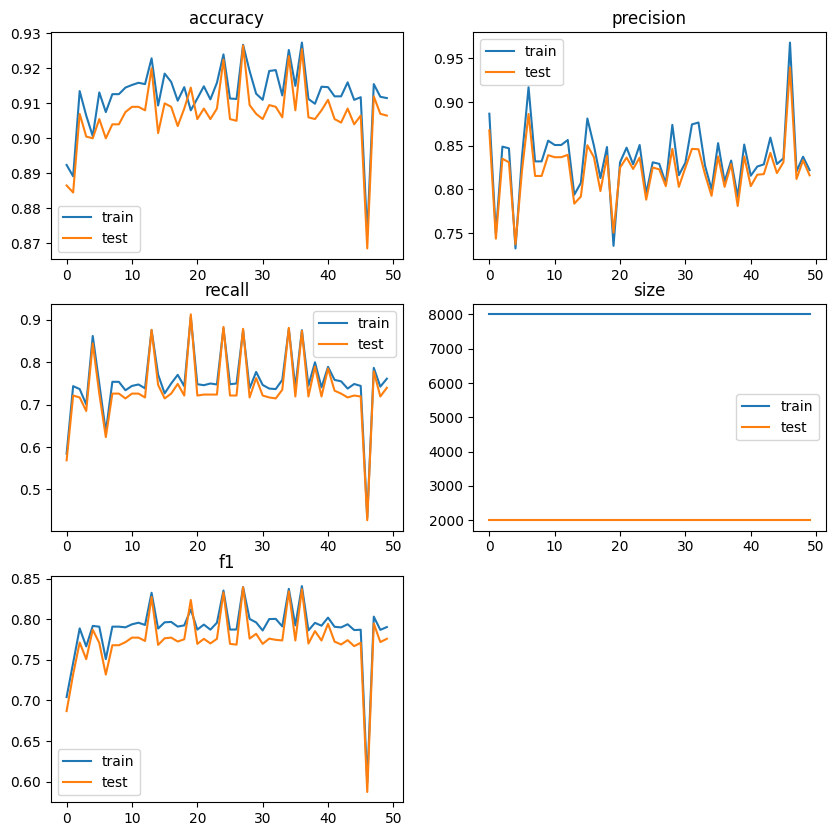

In [33]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_small.num_node_features,
                     num_classes=ds_small.num_classes, apply_dropout=False)
print(conv_model)

te = TrainEval(conv_model)
te.main(50, train_loader, test_loader)

ConvGNN(
  (conv1): GraphConv(1, 10)
  (conv2): GraphConv(10, 10)
  (conv3): GraphConv(10, 10)
  (lin): Linear(in_features=10, out_features=2, bias=True)
)
Epoch:  01, Train: accuracy=0.9131, precision=0.8760, recall=0.7087, size=8000.0000, f1=0.7836, Test: accuracy=0.9190, precision=0.8699, recall=0.7201, size=2000.0000, f1=0.7880
Epoch:  02, Train: accuracy=0.9189, precision=0.7633, recall=0.9194, size=8000.0000, f1=0.8341, Test: accuracy=0.9145, precision=0.7465, recall=0.8947, size=2000.0000, f1=0.8139
Epoch:  03, Train: accuracy=0.9139, precision=0.8287, recall=0.7713, size=8000.0000, f1=0.7989, Test: accuracy=0.9150, precision=0.8100, recall=0.7751, size=2000.0000, f1=0.7922
Epoch:  04, Train: accuracy=0.9134, precision=0.8228, recall=0.7769, size=8000.0000, f1=0.7992, Test: accuracy=0.9155, precision=0.8074, recall=0.7823, size=2000.0000, f1=0.7947
Epoch:  05, Train: accuracy=0.9135, precision=0.8225, recall=0.7780, size=8000.0000, f1=0.7997, Test: accuracy=0.9155, precision=0.8

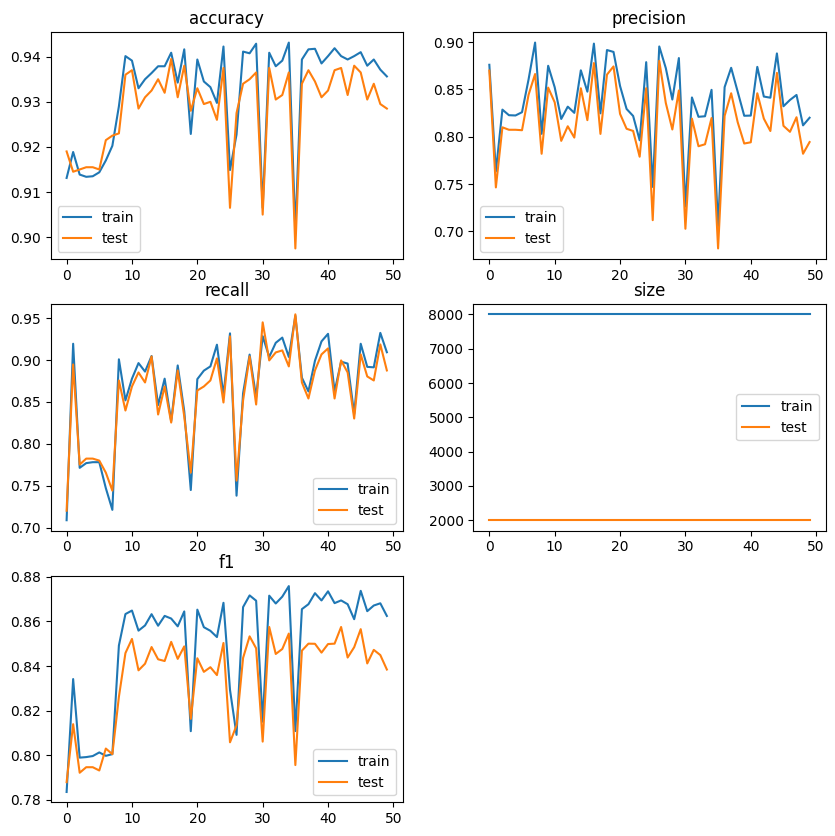

In [39]:
conv_model = ConvGNN(hidden_channels=10, num_node_features=ds_small.num_node_features,
                     num_classes=ds_small.num_classes, apply_dropout=False)
print(conv_model)

te = TrainEval(conv_model)
te.main(50, train_loader, test_loader)

# Playground 